In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge

RANDOM_STATE = 42
TRAIN_PATH = 'Video_Games.csv'
TEST_PATH = 'Video_Games_Test.csv'
TARGET = 'JP_Sales'


In [16]:
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print('train:', train_df.shape)
print('test :', test_df.shape)
train_df.head()

train: (11703, 15)
test : (5016, 15)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Rapala Trophies,PSP,2006.0,Sports,Activision,0.04,0.00,0.00,0.00,NaN,NaN,NaN,NaN,Sand Grain Studios,E
1,New Super Mario Bros. U,WiiU,2012.0,Platform,Nintendo,2.30,1.34,1.27,0.32,84.0,70.0,8.1,733.0,Nintendo,E
2,Robots,PS2,2005.0,Action,Vivendi Games,0.18,0.14,0.00,0.05,53.0,6.0,6.0,8.0,Eurocom Entertainment Software,E
3,Hamster Club 3,GBA,2002.0,Simulation,Jorudan,0.00,0.00,0.35,0.01,NaN,NaN,NaN,NaN,NaN,NaN
4,Formula 1 06,PS2,2006.0,Racing,Sony Computer Entertainment,0.00,0.00,0.04,0.00,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             11702 non-null  object 
 1   Platform         11703 non-null  object 
 2   Year_of_Release  11508 non-null  float64
 3   Genre            11702 non-null  object 
 4   Publisher        11665 non-null  object 
 5   NA_Sales         11703 non-null  float64
 6   EU_Sales         11703 non-null  float64
 7   JP_Sales         11703 non-null  float64
 8   Other_Sales      11703 non-null  float64
 9   Critic_Score     5676 non-null   float64
 10  Critic_Count     5676 non-null   float64
 11  User_Score       5319 non-null   float64
 12  User_Count       5319 non-null   float64
 13  Developer        7064 non-null   object 
 14  Rating           6957 non-null   object 
dtypes: float64(9), object(6)
memory usage: 1.3+ MB


None

,missing_%
User_Count,54.550115
User_Score,54.550115
Critic_Count,51.499615
Critic_Score,51.499615
Rating,40.553704
Developer,39.639409
Year_of_Release,1.666239
Publisher,0.324703
Name,0.008545
Genre,0.008545


JP_Sales zeros: 0.6255660941638896


count    11703.000000
mean         0.079129
std          0.319529
min          0.000000
25%          0.000000
50%          0.000000
75%          0.040000
max         10.220000
Name: JP_Sales, dtype: float64

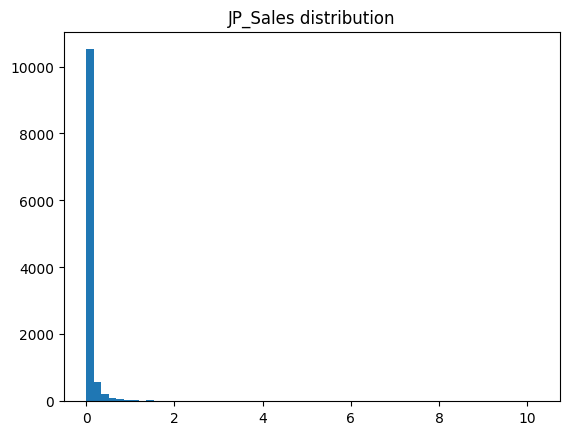

In [17]:
display(train_df.info())

missing = (train_df.isna().mean().sort_values(ascending=False) * 100)
display(missing.head(20).to_frame('missing_%'))

y = train_df[TARGET]
print('JP_Sales zeros:', (y == 0).mean())
display(y.describe())

plt.figure()
plt.hist(y, bins=60)
plt.title('JP_Sales distribution')
plt.show()

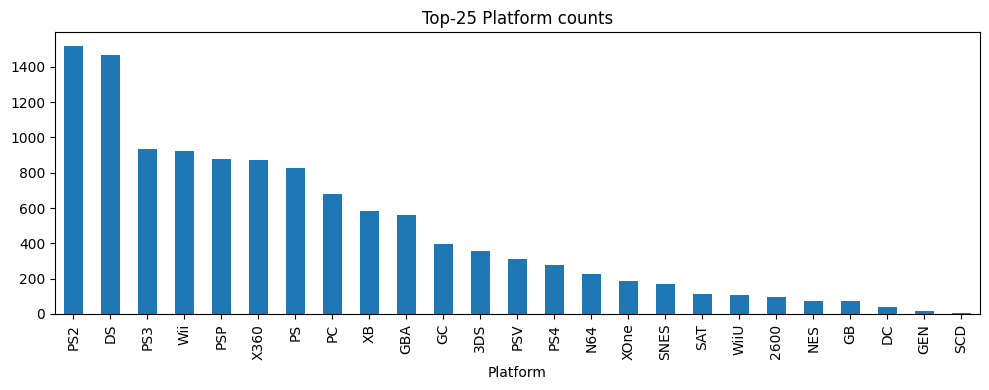

In [18]:
plt.figure(figsize=(10,4))
train_df['Platform'].value_counts().head(25).plot(kind='bar')
plt.title('Top-25 Platform counts')
plt.tight_layout()
plt.show()

In [19]:
baseline = np.full(shape=len(train_df), fill_value=y.median(), dtype=float)
print('Baseline MAE (median predictor):', mean_absolute_error(y, baseline))
# Важно: это MAE на train, но для константного предиктора он полезен как ориентир.

Baseline MAE (median predictor): 0.07912928308980603


In [20]:
# Разбиение на train/val
# Для воспроизводимости фиксируем random_state.
X = train_df.drop(columns=[TARGET])

# Часто полезно выкинуть 'Name' (почти уникален). Developer/Publisher можно оставить.
DROP_COLS = ['Name']
DROP_COLS = [c for c in DROP_COLS if c in X.columns]
X = X.drop(columns=DROP_COLS)

# User_Score иногда строка (например 'tbd') — приведём к числу.
if 'User_Score' in X.columns:
    X['User_Score'] = pd.to_numeric(X['User_Score'], errors='coerce')
if 'User_Score' in test_df.columns:
    test_df['User_Score'] = pd.to_numeric(test_df['User_Score'], errors='coerce')

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print(X_train.shape, X_val.shape)

(9362, 13) (2341, 13)


In [21]:
# Пайплайн препроцессинга (без утечек) + линейная модель
# Идея: числовые -> медиана + (опционально) стандартизация
#       категориальные -> '__MISSING__' + OneHotEncoder(handle_unknown='ignore')

# Автоматически определим типы по dtype
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']
num_cols = [c for c in X_train.columns if c not in cat_cols]
print('categorical:', len(cat_cols), cat_cols[:10])
print('numeric:', len(num_cols), num_cols)

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False)),
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency=50, sparse_output=True)),
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_cols),
        ('cat', categorical_pipe, cat_cols),
    ],
    remainder='drop'
)

# Ridge часто устойчивее OLS при большом one-hot
model = Ridge(alpha=1.0, random_state=RANDOM_STATE)

pipe = Pipeline(steps=[('preprocess', preprocess), ('model', model)])

pipe.fit(X_train, y_train)
pred_val = pipe.predict(X_val)
pred_val = np.clip(pred_val, 0, None)
print('VAL MAE:', mean_absolute_error(y_val, pred_val))

categorical: 5 ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
numeric: 8 ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'Other_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']
VAL MAE: 0.08045210743392792


In [22]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

X_cb = train_df.drop(columns=[TARGET] + DROP_COLS).copy()
y_cb = train_df[TARGET].copy()

# User_Score -> numeric
if 'User_Score' in X_cb.columns:
    X_cb['User_Score'] = pd.to_numeric(X_cb['User_Score'], errors='coerce')

Xtr, Xva, ytr, yva = train_test_split(X_cb, y_cb, test_size=0.2, random_state=RANDOM_STATE)

# categorical columns by dtype
cat_cols = [c for c in Xtr.columns if Xtr[c].dtype == 'object']

# fix categorical NaN
for c in cat_cols:
    Xtr[c] = Xtr[c].fillna('__MISSING__').astype(str)
    Xva[c] = Xva[c].fillna('__MISSING__').astype(str)

# (optional) numeric NaN -> median
num_cols = [c for c in Xtr.columns if c not in cat_cols]
for c in num_cols:
    Xtr[c] = pd.to_numeric(Xtr[c], errors='coerce')
    Xva[c] = pd.to_numeric(Xva[c], errors='coerce')
    med = Xtr[c].median()
    Xtr[c] = Xtr[c].fillna(med)
    Xva[c] = Xva[c].fillna(med)

train_pool = Pool(Xtr, ytr, cat_features=cat_cols)
val_pool   = Pool(Xva, yva, cat_features=cat_cols)

cbr = CatBoostRegressor(
    loss_function='MAE',
    eval_metric='MAE',
    iterations=25000,
    learning_rate=0.05,
    depth=8,
    random_seed=RANDOM_STATE,
    verbose=200
)

cbr.fit(train_pool, eval_set=val_pool, use_best_model=True)

pred = cbr.predict(val_pool)
pred = np.clip(pred, 0, None)

print('CatBoost VAL MAE:', mean_absolute_error(yva, pred))


0:	learn: 0.0815765	test: 0.0648352	best: 0.0648352 (0)	total: 11.5ms	remaining: 4m 47s
200:	learn: 0.0455156	test: 0.0464927	best: 0.0463545 (188)	total: 1.96s	remaining: 4m 2s
400:	learn: 0.0403410	test: 0.0462337	best: 0.0462337 (400)	total: 4.63s	remaining: 4m 44s
600:	learn: 0.0375766	test: 0.0460187	best: 0.0460093 (598)	total: 7.32s	remaining: 4m 57s
800:	learn: 0.0354296	test: 0.0460843	best: 0.0460026 (636)	total: 9.88s	remaining: 4m 58s
1000:	learn: 0.0339082	test: 0.0460920	best: 0.0459309 (860)	total: 12.4s	remaining: 4m 58s
1200:	learn: 0.0328450	test: 0.0461187	best: 0.0459309 (860)	total: 15.1s	remaining: 4m 58s
1400:	learn: 0.0318164	test: 0.0461978	best: 0.0459309 (860)	total: 17.8s	remaining: 4m 59s
1600:	learn: 0.0308513	test: 0.0463244	best: 0.0459309 (860)	total: 20.7s	remaining: 5m 2s
1800:	learn: 0.0301258	test: 0.0463235	best: 0.0459309 (860)	total: 23.5s	remaining: 5m 2s
2000:	learn: 0.0295032	test: 0.0463420	best: 0.0459309 (860)	total: 26.3s	remaining: 5m 2s


In [23]:
#  Обучение на всём train и генерация submission.csv
# Выберите одну модель: pipe (sklearn) или cbr (catboost).

# Вариант A: sklearn пайплайн
X_full = train_df.drop(columns=[TARGET]).drop(columns=DROP_COLS, errors='ignore')
y_full = train_df[TARGET]
if 'User_Score' in X_full.columns:
    X_full['User_Score'] = pd.to_numeric(X_full['User_Score'], errors='coerce')

test_X = test_df.drop(columns=DROP_COLS, errors='ignore').copy()
if 'User_Score' in test_X.columns:
    test_X['User_Score'] = pd.to_numeric(test_X['User_Score'], errors='coerce')

pipe.fit(X_full, y_full)
test_pred = pipe.predict(test_X)
test_pred = np.clip(test_pred, 0, None)

# Id: либо есть в тесте, либо нужно сделать 1..N
if 'Id' in test_df.columns:
    sub = pd.DataFrame({'Id': test_df['Id'], 'JP_Sales': test_pred})
else:
    sub = pd.DataFrame({'Id': np.arange(1, len(test_df)+1), 'JP_Sales': test_pred})

sub.to_csv('submission.csv', index=False)
sub.head()

,Id,JP_Sales
0,1,0.094496
1,2,0.006269
2,3,0.011525
3,4,0.000000
4,5,0.000000
